In [ ]:
#import modules
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack as fft
import scipy.signal as sig
import pandas as pd
import time

In [ ]:
from matplotlib import rc
from matplotlib import rcParams

rc('xtick', labelsize=15) 
rc('ytick', labelsize=15)

rc('axes', titlesize=15) 
rc('axes', labelsize=15) 
rc('axes', linewidth=2)

rcParams['legend.fontsize'] = 15
rcParams['patch.linewidth'] = 1
rcParams['axes.labelpad'] = 7

In [194]:
savepath = '/Users/melisatallis/Documents/Research/NRM/results/paramater_estimation_tau/'
dstr = time.strftime('%Y%m%d')

# Define filter, bath, and qubit decoherence factor  

G has to be a homogeneous function and depending on the freq, it has a different tau dependence. 
That is why the filter needs to probe different frequancy regions.  

In [209]:
#bath and decoherence factor
def bath(params,omega):
    '''
    G = bath(params,omega)
    
    Model to describe memory time scales of the environment, 
    also known as the generalized Ornstein-Uhlenbeck spectral density.
    
    Parameters
    ----------
    g : number
        Coupling strength 
    tau_c : number
        Correlation time  
    beta : number
        Type of noise process
    omega: array 
        Frequncices 

    Returns
    -------
    array
        An approximation of the spectral density of the noise.
    '''
    g = params[0]
    tau_c = params[1]
    beta = params[2]
    A = (beta*np.sin(np.pi/beta))/(2*np.pi)
    
    return g**2*A*tau_c/(1+(omega**beta*tau_c**beta))

#signal functions
def FID(t,t0):
    '''
    F = FID(t,t0)
    
    Rectangular wave function.  
    Width defaults to length of the timeseries if larger than the timeseries. 
    
    INPUT
    - t: list or array of numbers 
    - t0: Length of observation [Integer]
    
    OUTPUT
    - Fourier Transform of the rectangular function, squared [array]    
    
    '''
    n = len(t)  
    f_s = 1/(t[1]-t[0])
    width = t0*f_s
    y = np.piecewise(t,[t < t0, t > t0],[1,0])
    if t0 < t[-1]:
        norm = 1/width
    else:
        norm = 1/n
    yFT = fft.fftshift(fft.fft(y*norm))
    return ((t0*np.abs(yFT))**2)/(2)


def FID_t(omega,t0):
    '''
    F_t = FID_t(omega,t0)
    
    Analytical FID model 
    
    INPUT
    - omega: list of frequencies 
    - t0: Length of observation [Integer]
    
    OUTPUT
    - An approximation of the FID [array] 
    ''' 
    return ((t0*np.sinc(omega*t0))**2)/(2)

def J_t(m):
    return m*(1-np.exp(-m/2))/np.pi
    
    

Simulated timeseries data

In [212]:
# Generate time series
t_total = 100 # Seconds
f_s = 10  # Sampling rate, or number of measurements per second
n = t_total * f_s # Number of data points 
t = np.linspace(0.0,t_total,n,endpoint=False)
omega = fft.fftshift(fft.fftfreq(n,d=1/f_s))

Visualize Data

In [ ]:
# Check that numerical FID shape matches the analytical FID shape

%matplotlib notebook

t0 = 100 # time of observation
F = FID(t,t0) # Numerical
F_t = FID_t(omega,t0) # Analytical

plt.figure(figsize=[8,5.5])
plt.plot(omega,F,label = 'Numerical',lw=4)
plt.plot(omega,F_t,label = 'Analytical')
#plt.plot(omega,F_t**2, label = 'Analytical')
plt.legend()

#plt.savefig(savepath + 'FID_shape_analytical_vs_numerical' + '_' + dstr + '.pdf')    

In [ ]:
%matplotlib notebook

n_lines = 5
# Noise spectrum 
plt.figure(figsize = [8,5.5])
colors = plt.cm.magma_r(np.linspace(0,1,n_lines))
#colors = ['indianred','darkorange','gold','darkcyan','navy']

for i, tau in enumerate(np.linspace(0,10,n_lines)):
    params = [1,tau,2]
    G = bath(params,omega)
    plt.plot(omega,G,color = colors[i],
             label = r'$\tau_c$ = '+ str(params[1]) + ' sec')
    plt.hlines(np.max(G)/2,xmin=-1/tau,xmax=1/tau,linestyles='--',color=colors[i])

    
plt.xlim(-2,2)
plt.legend(frameon = False, borderpad = 1.5)
plt.xlabel(r'$\omega$'+' [Hz]')
plt.ylabel('Spectral Density')
plt.savefig(savepath + '_' + 'bath_various_taus' + '_' + dstr + '.png')
plt.savefig(savepath + '_' + 'bath_various_taus' + '_' + dstr + '.pdf')


Superimpose bath with extreme cases of FID

In [ ]:
%matplotlib notebook

fig = plt.figure(figsize=(17,5.5))

# case where t0 >> tau 
t0 = 100
tau = 10

params = [1,tau,2]
G = bath(params,omega)
F = FID(t,t0)

ax1 = fig.add_subplot(1,2,1)
ax1.plot(omega,F,label = 'FID (' + r'$t_0$ = '+ str(t0) + ' sec)',color = 'orange')
ax1.plot(omega,G,label = 'bath (' + r'$\tau_c$ = '+ str(params[1]) + ' sec)',color='Teal' )
ax1.fill_between(omega, F,color = 'cornsilk')
ax1.set_xlabel(r'$\omega$'+' [hz]')
ax1.set_ylabel('Spectral Density')
ax1.set_xlim(-1,1)
ax1.set_ylim(0,4)
ax1.legend()

# case where t0 << tau 
t0 = 1
tau = 10

params = [1,tau,2]
F = FID(t,t0)
F_t = FID_t(omega,t0) # Analytical

ax2 = fig.add_subplot(1,2,2)
ax2.plot(omega,F,label = 'FID (' + r'$t_0$ = '+ str(t0) + ' sec)',color = 'orange')
ax2.plot(omega,G,label = 'bath (' + r'$\tau_c$ = '+ str(params[1]) + ' sec)',color='teal' )
ax2.fill_between(omega, F,color = 'cornsilk')
ax2.set_xlabel(r'$\omega$'+' [hz]')
ax2.set_ylabel('Spectral Density')
ax2.set_xlim(-1,1)
ax2.set_ylim(0,4)
ax2.legend(loc='upper right')
plt.savefig(savepath + 'bath_FID_overlap_extreme_examples' + '_' + dstr + '.png')

Calcula el factor J para un caso

In [ ]:
def integrate(x,y):
    '''
    Area = integrate(x,y)
    
    Numerical integration function that computes the total area under a list of values,
    utilizing the midpoint method. 
    
    INPUT
    - x: list of indices [array] 
    - y: list of values [array] 
    
    OUTPUT
    - Total area under the list of values [float] 

    '''
    a = x[-1]
    b = x[0]
    N = len(x)
    dx = np.abs(b - a)/N
    y_mid = (y[:-1] + y[1:])/2.0
    return np.sum(y_mid*dx)

Calcula factor j para todo los casos de tau

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in multiply


<IPython.core.display.Javascript object>


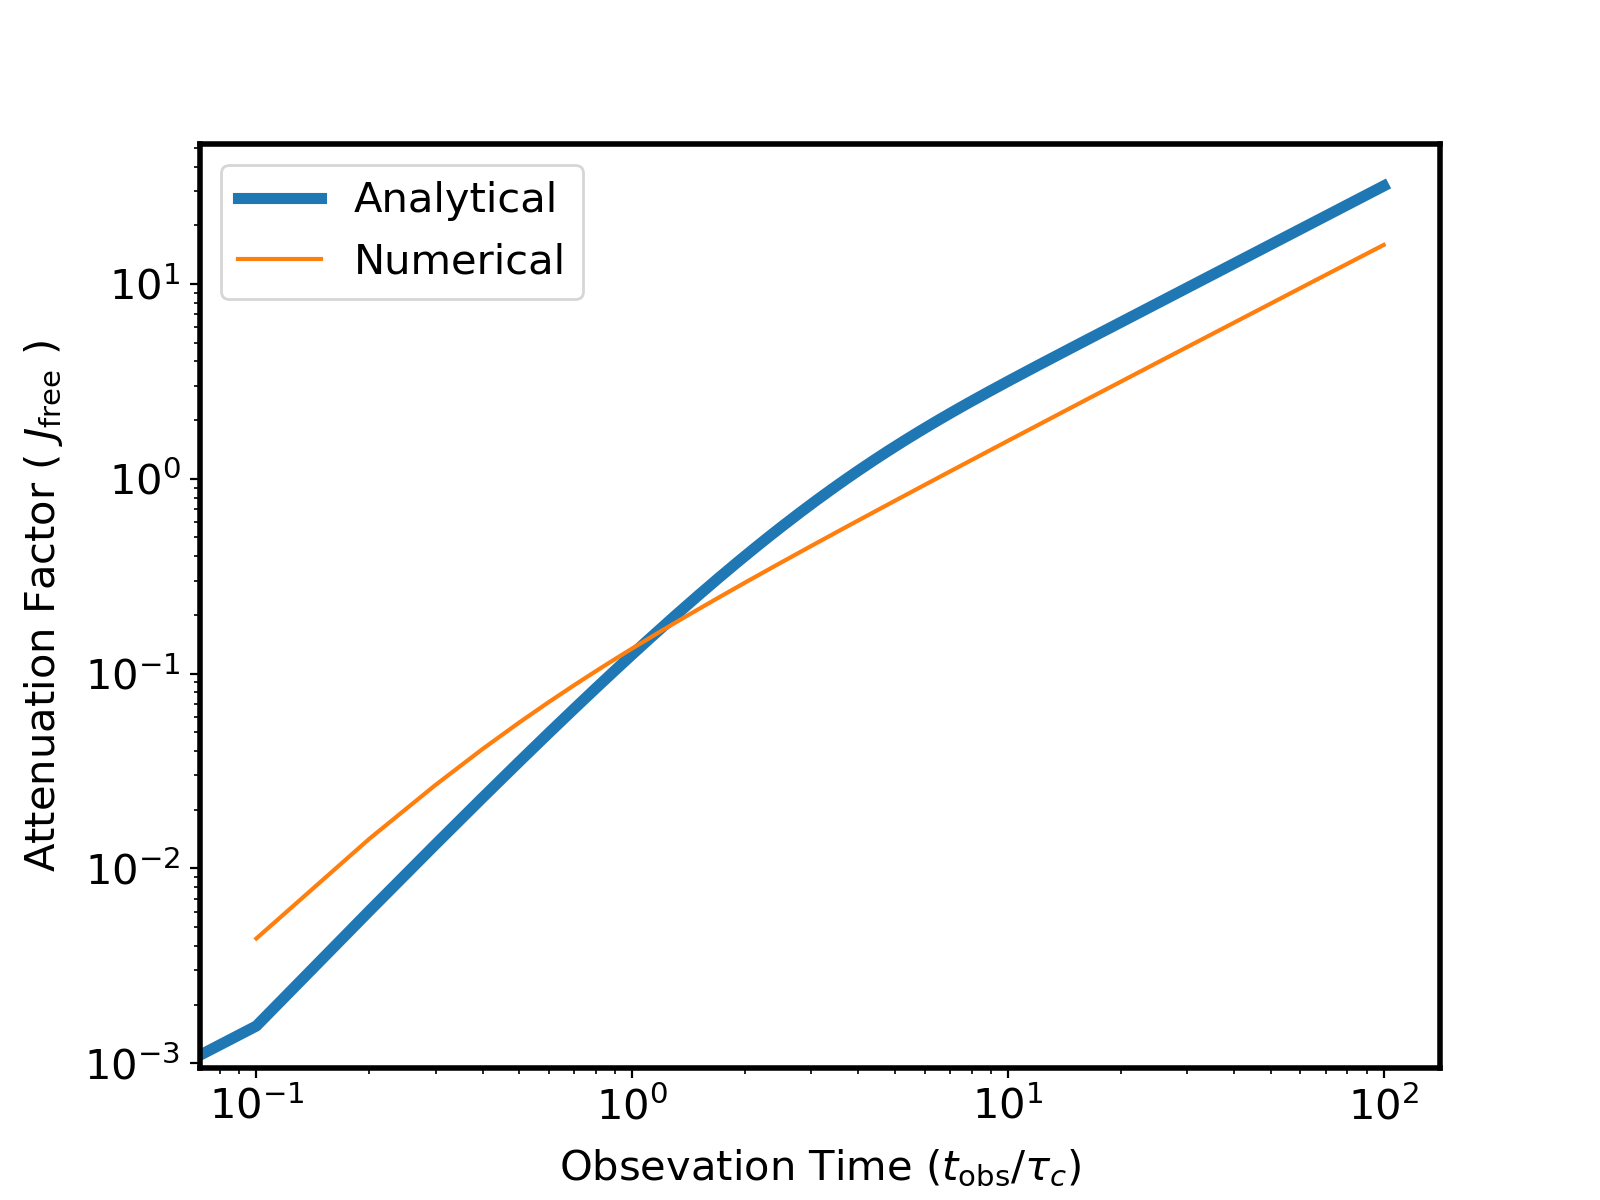

In [213]:
%matplotlib notebook

tau = 1
Js_t = []
Js_n = []


params = [1,tau,2]
G = bath(params,omega)

for t0 in t:
    F = FID(t,t0)
    J_n = integrate(omega,G*F)
    Js_n.append(J_n)

plt.figure(figsize=[8,6])   
plt.loglog(t/tau,J_t(t/tau),label = 'Analytical',lw=4)
plt.loglog(t/tau,np.array(Js_n),label = 'Numerical')
plt.ylabel(r'Attenuation Factor ( $J_{\rm free}$ )')
plt.xlabel(r'Obsevation Time ($t_{\rm obs}/\tau_c$)')
#plt.xlim(1,10**4)
plt.legend()


plt.savefig(savepath + 'decay_factor_vs_t_obs' + '_' + dstr + '.png')    
plt.savefig(savepath + 'decay_factor_vs_t_obs' + '_' + dstr + '.pdf')    


#pred_tau = np.argmin(np.abs(np.array(J_s)-0.8))
#print(pred_tau)
#plt.plot(t,J_s)